In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

In [2]:
!pip install einops

In [3]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# Preparing Data

In [4]:
# number of subprocesses to use for data loading
num_workers = 2
# how many samples per batch to load
batch_size = 100
# proportion of validation set to training set
valid_size = 0.2

# convert data to torch.FloatTensor
train_tfms = transforms.ToTensor()
valid_tfms = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=train_tfms)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=valid_tfms)

# split the training dataset into training set and validation set
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:],indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

# FashionMNIST Dataset

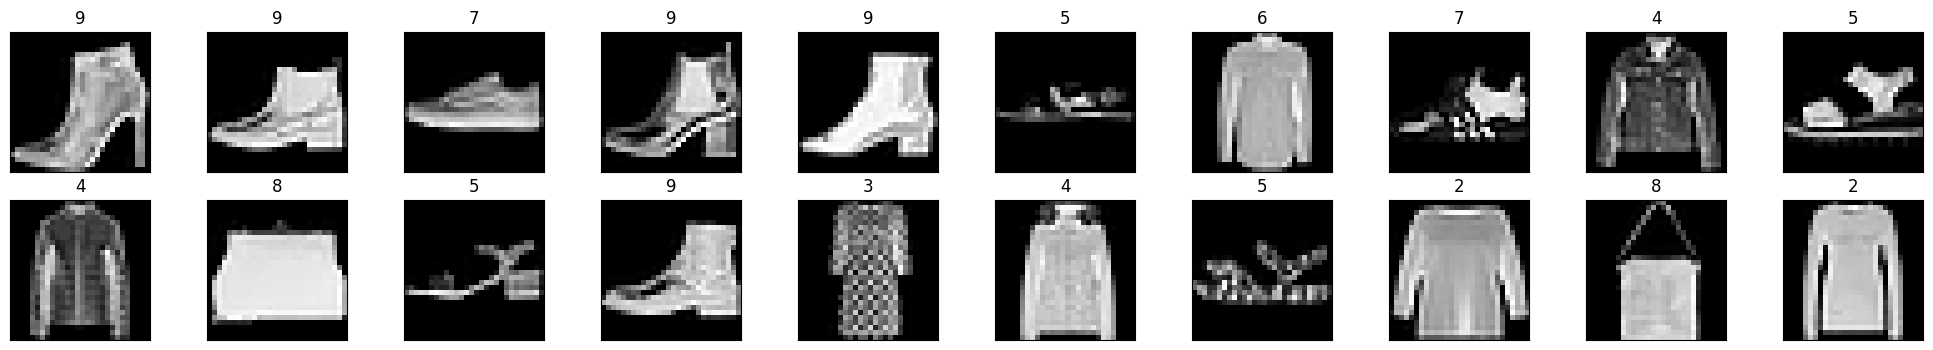

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

# Model Architecture

In [6]:
def to_patch(img):
      B, C, H, W = img.shape
      x = torch.zeros((B, 49, 16))
      for i in range(7):
        for j in range(7):
          x[:,i*7+j,:] = img[:,:,4*i:4*(i+1),4*j:4*(j+1)].reshape((B,16))

      return x.to(device)

## define the NN architecture
class Norm(nn.Module):
  """
  Layer normalization before multi-head attention block and mlp block in transformer encoder
  ViT architecture by: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
  https://arxiv.org/abs/2010.11929
  """
  def __init__(self, dim):
    super().__init__()
    self.norm = nn.LayerNorm(dim)

  def forward(self, x):
    return self.norm(x)

class MLP(nn.Module):
  """
  Mutilayer perceptron (MLP) or Feed-forward network (FFN) block in transformer encoder
  ViT architecture by: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
  https://arxiv.org/abs/2010.11929
  """
  def __init__(self, dim, hidden_dim, dropout = 0.):
    super().__init__()
    self.mlp = nn.Sequential(
        nn.Linear(dim, hidden_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, dim),
        nn.Dropout(dropout)
    )

  def forward(self, x):
    return self.mlp(x)

class Multi_Head_Attention(nn.Module):
  """
  Muti-head attention block in transformer encoder
  ViT architecture by: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
  https://arxiv.org/abs/2010.11929
  Muti-head attention architecure by: Attention Is All You Need
  https://arxiv.org/abs/1706.03762
  """
  def __init__(self, dim, num_head, dropout = 0.):
    super().__init__()
    dim_head = dim // num_head

    self.num_head = num_head
    self.sqrt_dk_r = dim_head ** (-0.5)
    self.dropout = nn.Dropout(dropout)

    self.QKV = nn.Linear(dim, dim * 3, bias = False)
    self.softmax = nn.Softmax(dim = -1)
    self.output = nn.Sequential(
        nn.Linear(dim, dim),
        nn.Dropout(dropout)
    ) if num_head > 1 else nn.Identity()

  def forward(self, x):
    """
    Parameters of shape comments:
    B  batch sizw
    H  image height
    W  image width
    PH patch height
    PW patch width
    D  dimension
    HD number of heads
    DH dimension each head
    """
    # Generate query, key and value (multiply by matrix Wq, Wk, Wv) by passing through an nn.Linear layer (learning)
    # and split into Q, K, V 3 chunks
    qkv = self.QKV(x).chunk(3, dim = -1)                                # (B, (H/PH)*(W/PW)+1, D) -> (B, (H/PH)*(W/PW)+1, D) * 3

    # Split Q, K, V into num_head heads (e.g. num_head=4, dim=64)
    # (0-15 1st head, 16-31 2nd head, 32-47 3rd head, 48-63 4th head)
    q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.num_head), qkv) # (B, (H/PH)*(W/PW)+1, D) -> (B, HD, (H/PH)*(W/PW)+1, DH)

    # Calculate attention score alpha = Q * K^T / sqrt(dk)
    alpha = torch.matmul(q, k.transpose(-1, -2)) * self.sqrt_dk_r                   # (B, HD, (H/PH)*(W/PW)+1, (H/PH)*(W/PW)+1)

    # Calculate attention matrix attention = softmax(alpha)
    attention = self.softmax(alpha)                                    # (B, HD, (H/PH)*(W/PW)+1, (H/PH)*(W/PW)+1)

    # Calculate output out = attention * V
    out = torch.matmul(attention, v)                                   # (B, HD, (H/PH)*(W/PW)+1, DH)

    # Concatenate all the heads
    out = rearrange(out, 'b h n d -> b n (h d)')                         # (B, HD, (H/PH)*(W/PW)+1, DH) -> (B, (H/PH)*(W/PW)+1, D)

    # Multiply by matrix Wo by passing through an nn.Linear layer (learning)
    out = self.output(out)                                        # (B, (H/PH)*(W/PW)+1, D)

    return out

class Transformer_Encoder(nn.Module):
  """
  Transformer encoder in ViT model
  ViT architecture by: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
  https://arxiv.org/abs/2010.11929
  """
  def __init__(self, dim, num_head, hidden_dim_ratio, dropout = 0.):
    super().__init__()
    self.norm = Norm(dim)
    self.mha = Multi_Head_Attention(dim, num_head, dropout)
    self.mlp = MLP(dim, dim * hidden_dim_ratio, dropout)

  def forward(self, x):
    x = self.mha(self.norm(x)) + x
    x = self.mlp(self.norm(x)) + x
    return x

class ViT(nn.Module):
  """
  ViT architecture by: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
  https://arxiv.org/abs/2010.11929
  """
  def __init__(self, image_size, patch_size, num_channel, num_class, depth, dim, num_head, hidden_dim_ratio, dropout = 0., embed_dropout = 0.):
    super().__init__()
    image_height, image_width = image_size, image_size
    patch_height, patch_width = patch_size, patch_size
    patch_dim = num_channel * patch_height * patch_width
    num_patch = (image_height // patch_height) * (image_width // patch_width)

    self.image_to_patch = to_patch
    self.patch_embedding = nn.Linear(patch_dim, dim)

    self.class_token = nn.Parameter(torch.randn(1, 1, dim))
    self.pos_embedding = nn.Parameter(torch.randn(1, num_patch + 1, dim))
    self.dropout = nn.Dropout(embed_dropout)

    self.transformer = nn.ModuleList([
        Transformer_Encoder(
            dim, num_head, hidden_dim_ratio, dropout
        )for _ in range(depth)
    ])

    self.norm = Norm(dim)
    self.classification = nn.Linear(dim, num_class)

  def forward(self, x):
    # Transform image into patches
    x = self.image_to_patch(x)                            # (B, C, H, W) -> (B, (H/PH)*(W/PW), PH*PW*C)

    # Patch embedding
    x = self.patch_embedding(x)                           # (B, (H/PH)*(W/PW), PH*PW*C) -> (B, (H/PH)*(W/PW), D)

    # Class tokens
    batch_size = x.shape[0]
    cls_token = repeat(self.class_token, '1 1 d -> b 1 d', b = batch_size) # (B, 1, D)

    # Conatenate class tokens to embedded patches
    x = torch.cat((cls_token, x), dim = 1)                    # (B, (H/PH)*(W/PW), D) -> (B, (H/PH)*(W/PW)+1, D)

    # Position embedding
    x = x + self.pos_embedding                           # (B, (H/PH)*(W/PW)+1, D) shape unchanged, element-wise addition
    x = self.dropout(x)

    # Transfomer encoders with depth layers
    for layer in self.transformer:
      x = layer(x)                                 # (B, (H/PH)*(W/PW)+1, D) shape unchanged

    # Take the class token for classification
    x = x[:, 0]                                   # (B, (H/PH)*(W/PW)+1, D) -> (B, D)

    # MLP Head block for classification
    x = self.norm(x)
    x = self.classification(x)                            # (B, D) -> (B, CLS)

    return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViT(
    image_size = 28,
    patch_size = 4,
    num_channel = 1,
    num_class = 10,
    depth = 4,
    dim = 64,
    num_head = 4,
    hidden_dim_ratio = 4,
    dropout = 0.2,
    embed_dropout = 0.2
).to(device)

print(model)

ViT(
  (patch_embedding): Linear(in_features=16, out_features=64, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (transformer): ModuleList(
    (0-3): 4 x Transformer_Encoder(
      (norm): Norm(
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (mha): Multi_Head_Attention(
        (dropout): Dropout(p=0.2, inplace=False)
        (QKV): Linear(in_features=64, out_features=192, bias=False)
        (softmax): Softmax(dim=-1)
        (output): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): Dropout(p=0.2, inplace=False)
        )
      )
      (mlp): MLP(
        (mlp): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.2, inplace=False)
          (3): Linear(in_features=256, out_features=64, bias=True)
          (4): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (norm): Norm(
    (norm): LayerNo

# Hyperparameters

In [8]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# number of epochs to train the model
n_epochs = 10

# specify optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.75, momentum=0.8)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0004, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.9)

# specify leaning rate scheduler
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.0004, epochs=n_epochs, steps_per_epoch=len(train_loader))
# sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

# Training and Validation

In [9]:
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity
# initialize history for recording what we want to know
history = []

for epoch in range(n_epochs):
    # monitor training loss, validation loss and learning rate
    train_loss = 0.0
    valid_loss = 0.0
    lrs    = []
    result = {'train_loss': [], 'val_loss': [], 'lrs': []}

    # prepare model for training
    model.train()

    #######################
    # train the model #
    #######################
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()

        # record learning rate
        lrs.append(optimizer.param_groups[0]['lr'])
        # update learning rate
        sched.step()

        # update running training loss
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################

    model.eval()
    for data,target in valid_loader:
        data, target = data.to(device), target.to(device)
        # compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,target)
        # update running validation loss
        valid_loss += loss.item()*data.size(0)

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_sampler)
    result['train_loss'] = train_loss
    valid_loss = valid_loss/len(valid_sampler)
    result['val_loss'] = valid_loss
    leaning_rate = lrs
    result['lrs'] = leaning_rate
    history.append(result)
    # update learning rate
    # sched.step()

    print('Epoch {:2d}: Learning Rate: {:.6f} Training Loss: {:.6f} Validation Loss:{:.6f}'.format(
        epoch+1,
        leaning_rate[-1],
        train_loss,
        valid_loss
        ))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print("Validation loss decreased({:.6f}-->{:.6f}). Saving model ..".format(
        valid_loss_min,
        valid_loss
        ))
        torch.save(model.state_dict(),"model.pt")
        valid_loss_min = valid_loss

Epoch  1: Learning Rate: 0.000112 Training Loss: 1.188274 Validation Loss:0.668037
Validation loss decreased(inf-->0.668037). Saving model ..
Epoch  2: Learning Rate: 0.000304 Training Loss: 0.629803 Validation Loss:0.587919
Validation loss decreased(0.668037-->0.587919). Saving model ..
Epoch  3: Learning Rate: 0.000400 Training Loss: 0.551054 Validation Loss:0.514070
Validation loss decreased(0.587919-->0.514070). Saving model ..
Epoch  4: Learning Rate: 0.000380 Training Loss: 0.503862 Validation Loss:0.437893
Validation loss decreased(0.514070-->0.437893). Saving model ..
Epoch  5: Learning Rate: 0.000325 Training Loss: 0.466988 Validation Loss:0.424067
Validation loss decreased(0.437893-->0.424067). Saving model ..
Epoch  6: Learning Rate: 0.000245 Training Loss: 0.445914 Validation Loss:0.397088
Validation loss decreased(0.424067-->0.397088). Saving model ..
Epoch  7: Learning Rate: 0.000155 Training Loss: 0.420442 Validation Loss:0.374889
Validation loss decreased(0.397088-->0.3

# Plot Learning Rate Curve

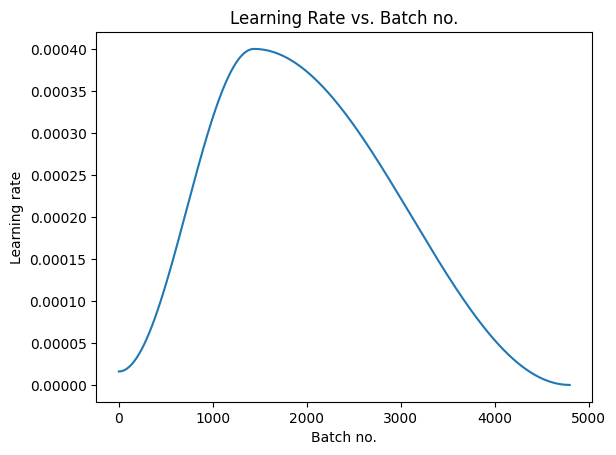

In [10]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch no.')
  plt.ylabel('Learning rate')
  plt.title('Learning Rate vs. Batch no.');

plot_lrs(history)

# Plot Loss Curve

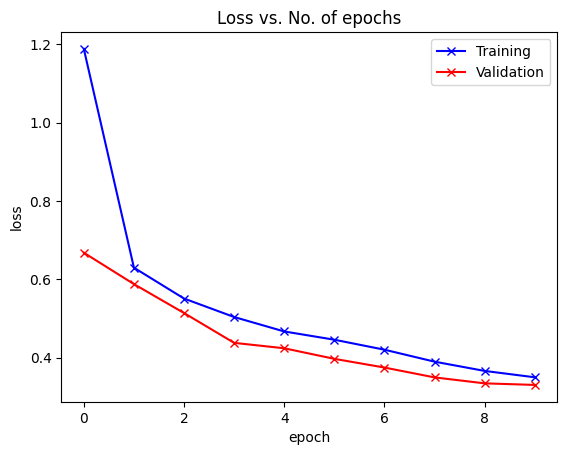

In [11]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs');

plot_losses(history)

# Testing

In [12]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# prep model for evaluation
model.eval()

for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of Class %5s: %2.2f%% (%2d/%2d)' % (
            str(i),
            100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]),
            np.sum(class_total[i])
            ))
    else:
        print('Test Accuracy of Class %5s: N/A (no training examples)' % (str[i]))

print('\nTest Accuracy (Overall): %2.2f%% (%2d/%2d)' % (
    100 * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct),
    np.sum(class_total)
    ))

Test Loss: 0.358496

Test Accuracy of Class     0: 83.00% (830/1000)
Test Accuracy of Class     1: 96.80% (968/1000)
Test Accuracy of Class     2: 78.30% (783/1000)
Test Accuracy of Class     3: 88.70% (887/1000)
Test Accuracy of Class     4: 79.50% (795/1000)
Test Accuracy of Class     5: 92.90% (929/1000)
Test Accuracy of Class     6: 65.90% (659/1000)
Test Accuracy of Class     7: 93.40% (934/1000)
Test Accuracy of Class     8: 96.00% (960/1000)
Test Accuracy of Class     9: 94.90% (949/1000)

Test Accuracy (Overall): 86.94% (8694/10000)
